In [29]:
### Library Import 
import os
import re
import sys
import glob
import shap
import optuna
import pickle
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
from functools import partial
from xgboost import XGBRegressor, callback as xgb_callback
from datetime import timedelta, time, datetime
from scipy.stats import truncnorm
from IPython.display import Image
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
warnings.filterwarnings('ignore')
plt.rc('font', family='Apple SD Gothic Neo')

# Pandas 옵션 설정 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)


In [30]:
import pandas as pd
from pandarallel import pandarallel
import numpy as np
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
import xgboost as xgb
import matplotlib.pyplot as plt
import json
from utils import *

plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False

user = "dogyeom"

In [31]:
cluster_dict = {
    'cluster1': {'products': ["FFWED70284","FFWED70007","FFWED70267","FFWED70103","FFWED70199","FFSED70438","FFWED70033",
                              "FFWES60194","FFSED70498","FFSED70533","FFWED70321"],
                 'var': 'T5'},
    'cluster2': {'products': ["FFWED70019","FFWED70102","FFWED70283","FFHED70076","FFWED70338",
                              "FFHED70014","FFSED70032","FFHED70147",
                              "FFHED60009","FFHED60006"],
                 'var': 'T3'},
    'cluster3': {'products': ["HCSED50105", "HCSED60072",
                              "HCWED60031", "HCSED50391", "HCSED70092", "HCSED60024",],
                 'var': 'M/B 점도 (ML)'},
    'cluster4': {'products': ["HCSED60010", "HCSES60015", "HCWES60017",
                              "HCSED70584", "HCSED60530", "HCSED50047",
                              "HCSED40011", "HCSED20006",
                              "HCWED70019", "FCHED60002", "FCWED70009",
                              "HCSED60017", "HCSED70143"],
                 'var': 'M/B 점도 (MS)'}
    }

# def divide_step_log_df(log_df: pd.DataFrame) -> pd.DataFrame:
#     """
#     공정 데이터 스텝 나누는 코드, 병렬 처리로 효율적
    
#     required_columns:
#     - mix시간
#     - 작업지시번호-배치
#     """
#     # 병렬 초기화
#     pandarallel.initialize(progress_bar=True)

#     # 스텝 할당 함수
#     def assign_steps(df):
#         mix = df["mix시간"].values
#         steps = np.zeros(len(mix), dtype=int)

#         i = 0
#         step_num = 1
#         while i < len(mix) and step_num <= 3:
#             while i < len(mix) and mix[i] == 0:
#                 i += 1
#             start = i

#             while i < len(mix) and mix[i] > 0:
#                 i += 1
#             end = i

#             steps[start:end] = step_num
#             step_num += 1

#         df["step"] = steps
#         return df

#     # 병렬로 그룹별 step 할당
#     log_df = log_df.groupby("작업지시번호-배치", group_keys=False).parallel_apply(
#         assign_steps
#     )

#     return log_df

# def log_to_train_df(log_df: pd.DataFrame) -> pd.DataFrame:
#     """
#     초단위 데이터를 "작업지시번호-배치"와 "step"별로 통계값을 구하고 (램압력과 로터스피드는 mean, 믹스온도는 max),
#     step별로 파생변수를 생성
    
#     required_columns:
#     - Ram 압력
#     - Rotor speed
#     - mix온도
#     - mix시간
#     - 작업지시번호-배치: 작업지시번호와 배치번호를 합친 문자열
#     - 시간: log 데이터의 시간 정보
#     - step
#     - 연월일
#     """

#     pandarallel.initialize(progress_bar=True)
    
#     # === 1) 필요한 컬럼 정의: '연월일'을 반드시 포함하도록 수정 ===
#     log_features = ["Ram 압력", "Rotor speed", "mix온도"]
#     required_columns = ["작업지시번호-배치", "step", "시간", "연월일"] + log_features
#     df = log_df.loc[:, required_columns].copy()

#     # === 2) 시간 전처리: 마이크로초 제거는 벡터화로 대체(성능/간결성) ===
#     #    기존: 문자열->regex->to_datetime
#     #    개선: 곧바로 to_datetime 후 초 단위로 내림
#     df["시간"] = pd.to_datetime(
#         df["시간"].astype(str).str.replace(r"\.\d*", "", regex=True), errors="coerce"
#     )

#     # === 3) 유효 row 필터 ===
#     df = df[df["시간"].notna() & (df["step"] != 0)]

#     # === 4) (배치, step) 집계: mean/max와 time(second) 한 번에 구성 ===
#     grouped = df.groupby(["작업지시번호-배치", "step"], sort=False)

#     agg_df = grouped.agg({
#         "Ram 압력": "mean",
#         "Rotor speed": "mean",
#         "mix온도": "max"
#     })
#     time_sec = grouped["시간"].agg(lambda s: (s.max() - s.min()).total_seconds()).rename("time")

#     step_df = pd.concat([agg_df, time_sec], axis=1).reset_index()

#     # === 5) 와이드화(pivot) ===
#     wide = step_df.pivot_table(
#         index="작업지시번호-배치",
#         columns="step",
#         values=["Ram 압력", "Rotor speed", "mix온도", "time"],
#         aggfunc="first",
#     )

#     # 컬럼명 정리: step{n}_{col}
#     wide.columns = [f"step{int(step)}_{col}" for col, step in wide.columns]
#     wide = wide.reset_index()

#     # === 6) 배치 단위 '연월일' 산출 후 조인(길이 불일치 해결의 핵심) ===
#     # 배치 내 중복 날짜가 있을 수 있으므로 mode 우선, 없으면 첫 값 사용
#     date_per_batch = (
#         df.groupby("작업지시번호-배치")["연월일"]
#           .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
#           .reset_index()
#     )

#     result = wide.merge(date_per_batch, on="작업지시번호-배치", how="left")

#     return result

# def plot_predictions(y_true, y_pred, title, subtitle=None):
#     df = pd.DataFrame({"true": y_true, "pred": y_pred}).reset_index(drop=True)
#     df.sort_values("true").reset_index(drop=True).plot(
#         alpha=0.6, title=title
#     )
#     if subtitle:
#         plt.xlabel(subtitle)
#     plt.legend(["true", "pred"])
#     plt.show()
    

# def _inject_ref_features(params_dict: dict) -> dict:
#     """영향변수(ref_features: stepk_time)를 관계식으로 계산해 params_dict에 덮어씀"""
#     for k in [1, 2, 3]:
#         m_key  = f"step{k}_mix온도"
#         mt_key = f"step{k}_mix온도Xtime"
#         t_key  = f"step{k}_time"

#         m  = params_dict.get(m_key, None)
#         mt = params_dict.get(mt_key, None)

#         # 두 값이 모두 있어야 계산 가능. 없으면 그대로 두되, 모델 입력 전에 NaN 검사 권장.
#         if m is not None and mt is not None:
#             # 0 나눗셈 방지
#             if m == 0 or (isinstance(m, float) and np.isclose(m, 0.0)):
#                 params_dict[t_key] = np.nan  # 혹은 큰 패널티를 주는 방식
#             else:
#                 params_dict[t_key] = mt / m
#     return params_dict


# def create_objective_function(
#     fixed_params, all_features_list, opt_features_list, 
#     ct_target=None, st_target=None, c_target=None, v_target=None, h_target=None,
#     penalty_invalid=1e6, scales=None, weights=None
# ):
#     """고정 조건과 최적화 대상을 조합해 모델을 예측하는 함수를 생성"""
    
#     scales = scales or {}
#     weights = weights or {}
    

#     def _safe_scale(key: str, default: float = 1.0) -> float:
#         s = scales.get(key, default)
#         try:
#             s = float(s)
#         except Exception:
#             s = default
#         # 0 / 비정상값 방지
#         if (s is None) or (not np.isfinite(s)) or (s <= 0):
#             s = default
#         return s
    
#     def _safe_weight(key: str, default: float = 1.0) -> float:
#         w = weights.get(key, default)
#         try:
#             w = float(w)
#         except Exception:
#             w = default
#         # 0 / 비정상값 방지
#         if (w is None) or (not np.isfinite(w)) or (w <= 0):
#             w = default
#         return w

#     def objective(opt_params_values):
#         # 값 생성
#         params_dict = dict(fixed_params)  # 고정변수 삽입
#         for name, val in zip(opt_features_list, opt_params_values):
#             params_dict[name] = val
            
#         # ▼ 순서 제약: step1 < step2 < step3  (엄격 '>' 조건)
#         t1 = params_dict.get("step1_mix온도", None)
#         t2 = params_dict.get("step2_mix온도", None)
#         t3 = params_dict.get("step3_mix온도", None)
#         if (t1 is None) or (t2 is None) or (t3 is None) or \
#            (not np.isfinite(t1)) or (not np.isfinite(t2)) or (not np.isfinite(t3)) or \
#            not (t1 <= t2 <= t3):
#             return penalty_invalid
#         # (만약 '크거나 같다'로 완화하려면 위 마지막 조건을: not (t1 <= t2 <= t3) 로 변경)

#         params_dict = _inject_ref_features(params_dict)

#         try:
#             final_params_vector = [params_dict[f] for f in all_features_list]
#         except KeyError as e:
#             # 빠진 피처가 있으면 바로 패널티
#             return penalty_invalid
        
#         # df 생성
#         prediction_input_df = pd.DataFrame(
#             [final_params_vector], columns=all_features_list
#         )
        
#         # NaN/inf 검사 → 불능 조합 패널티
#         if not np.isfinite(prediction_input_df.to_numpy(dtype=float)).all():
#             return penalty_invalid

#         preds = {}
#         if ct_target  is not None: preds["ct"]  = model_ct_best.predict(prediction_input_df)[0]
#         if st_target  is not None: preds["st"] = model_st_best.predict(prediction_input_df)[0]
#         if c_target   is not None: preds["c"]   = model_c_best.predict(prediction_input_df)[0]
#         if v_target   is not None: preds["v"]   = model_v_best.predict(prediction_input_df)[0]
#         if h_target   is not None: preds["h"]   = model_h_best.predict(prediction_input_df)[0]

#         norm_errors = []
#         if ct_target is not None: 
#             e = abs(preds["ct"] - ct_target) / _safe_scale("ct")
#             norm_errors.append(_safe_weight("ct") * e)
#         if st_target is not None:
#             e = abs(preds["st"] - st_target) / _safe_scale("st")
#             norm_errors.append(_safe_weight("st") * e)
#         if c_target is not None:
#             e = abs(preds["c"] - c_target) / _safe_scale("c")
#             norm_errors.append(_safe_weight("c") * e)
#         if v_target is not None:
#             e = abs(preds["v"] - v_target) / _safe_scale("v")
#             norm_errors.append(_safe_weight("v") * e)
#         if h_target is not None:
#             e = abs(preds["h"] - h_target) / _safe_scale("h")
#             norm_errors.append(_safe_weight("h") * e)

#         if not norm_errors:
#             return penalty_invalid

#         labels = {
#             "ct":  ("Ct 90", ct_target),
#             "st":  ("Scorch", st_target),
#             "c":   ("Cycle Time", c_target),
#             "v":   ("Viscosity", v_target),
#             "h":   ("Hardness", h_target),
#         }
#         logs = []
#         for k, (label, tgt) in labels.items():
#             if k in preds:
#                 logs.append(f"{label}: {preds[k]:.4f} (target {tgt})")
#         if logs:
#             print(" | ".join(logs))


#         return float(sum(norm_errors))

#     return objective

# 데이터 로딩

In [32]:
# 학습
train_cluster = "cluster1"
p_codes = cluster_dict[train_cluster]['products']
target_list = ["Ct 90"] + ["Scorch (T5)", "Scorch (T3)"] + ['Vm (T5)', "Vm (T3)", "M/B 점도 (ML)", "M/B 점도 (MS)"] + ["경도"]
random_seed = 42

In [33]:
path = '/Users/hwijongim/Library/CloudStorage/OneDrive-앰버로드/문서 - Solution/2502_화승/20.수행/22.분석과제/250408_분석_sm'

# log2022_df = pd.read_parquet(f"{path}/log_df_2022.parquet")
# log2023_df = pd.read_parquet(f"{path}/log_df_2023.parquet")
# log2024_df = pd.read_parquet(f"{path}/log_df_2024.parquet")

qa_df = pd.read_csv(f"{path}/qa_df.csv")
recipe_df = pd.read_csv(f"{path}/recipe_df.csv")
weather_df = pd.read_csv(f"{path}/weather_dg.csv")
# log_df = pd.concat([log2022_df, log2023_df, log2024_df], axis=0)
log_df = pd.read_csv(f"{path}/log_df_10s.csv")
log_df = log_df[log_df["제품코드"].isin(cluster_dict[train_cluster]["products"])]
info = pd.read_excel(f"{path}/투입자재 CODE별 비중 정보.xlsx", header=1, index_col=0).reset_index(drop=True)

# 레시피 데이터 정제
- 필팩터 변수 생성

In [34]:
recipe_df

,작업지시번호,B/T,자재코드,소요량,실적중량,STEP,오프라인계량,오차중량,낙차중량,공급중량,제로중량,투입유형,작업지시번호-배치
0,211230HCSED400110184,1,R3931-0127,17.900,17.910,1.0,N,0.200,0.0,0.05,NaN,M,211230HCSED400110184-1
1,211230HCSED400110184,1,R3941-0024,13.400,13.369,1.0,N,0.200,NaN,NaN,NaN,M,211230HCSED400110184-1
2,211230HCSED400110184,1,R3941-0042,13.400,13.306,1.0,N,0.200,NaN,NaN,NaN,M,211230HCSED400110184-1
3,211230HCSED400110184,1,R3962-0002,2.240,2.227,1.0,N,0.050,NaN,NaN,NaN,M,211230HCSED400110184-1
4,211230HCSED400110184,1,R3968-0002,0.900,0.891,1.0,N,0.020,NaN,NaN,NaN,M,211230HCSED400110184-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813067,250526FFSED706410057,8,R3970-0032,0.380,0.379,1.0,N,0.001,0.0,NaN,NaN,M,250526FFSED706410057-8
1813068,250526FFSED706410057,8,R3961-0057,0.875,0.875,10.0,N,0.001,NaN,NaN,NaN,R,250526FFSED706410057-8
1813069,250526FFSED706410057,8,R3961-0059,0.345,0.344,10.0,N,0.001,NaN,NaN,NaN,R,250526FFSED706410057-8
1813070,250526FFSED706410057,8,R3961-0063,0.415,0.414,10.0,N,0.001,NaN,NaN,NaN,R,250526FFSED706410057-8


In [35]:
recipe_df2 = pd.merge(recipe_df, info, left_on="자재코드", right_on="자재코드", how="left")

# 투입 자재코드가 2개 이하인 "작업지시번호-배치" 제거
rare_batches = recipe_df2["작업지시번호-배치"].value_counts(ascending=True)
rare_batches = rare_batches[rare_batches <= 2].index
recipe_df3 = recipe_df2[~recipe_df2["작업지시번호-배치"].isin(rare_batches)]

# # "원자재 비중" 컬럼의 결측값이 있는 "작업지시번호-배치" 제거
# recipe_df3 = recipe_df3.groupby("작업지시번호-배치").filter(
#     lambda x: not x["원자재 비중"].isna().any()
# )

# # "원자재 비중" 컬럼의 결측값을 1로 채움, 실제로는 바로 위 주석된 코드로 결측값 있는 배치를 제거하는 것이 더 정확
recipe_df3["원자재 비중"] = recipe_df3["원자재 비중"].fillna(1.32)

# 작업지시번호와 배치번호를 합쳐서 "작업지시번호-배치" 컬럼 생성
recipe_df3["작업지시번호-배치"] = (
    recipe_df3["작업지시번호"] + "-" + recipe_df3["B/T"].astype(int).astype(str)
)

# "부피" 컬럼 생성: 부피 = 실적중량 / 원자재 비중
recipe_df3["부피"] = recipe_df3["실적중량"] / recipe_df3["원자재 비중"]

# "작업지시번호-배치"를 기준으로 그룹화하여 실적중량의 합계를 구하고, 필팩터 계산 (챔버부피 150cm3으로 가정)
fillfactor = recipe_df3.groupby("작업지시번호-배치").sum()["부피"] / 190

# "작업지시번호-배치"를 기준으로 그룹화하여 실적중량의 합계를 구하고, 필팩터 계산
# fillfactor_before = recipe_df3.groupby("작업지시번호-배치").sum()["실적중량"] * 0.8 / 190

# "작업지시번호-배치"를 인덱스로 설정하고, recipe_df2에 필팩터를 병합
recipe_df4 = recipe_df3.merge(
    fillfactor.rename("필팩터"), 
    left_on="작업지시번호-배치", 
    right_index=True
)

# 필요한 컬럼만 선택하여 최종 DataFrame 생성
recipe_df5 = recipe_df4[["작업지시번호-배치", "필팩터"]]

# "작업지시번호-배치"하나에 "필팩터" 하나
recipe_df6 = recipe_df5.groupby("작업지시번호-배치", as_index=False).agg(
    {"필팩터": lambda x: x.mode()[0] if not x.mode().empty else np.nan}
)

In [36]:
# # 원자재 비중 값이 없는 작업지시번호-배치 개수
# aa = recipe_df2.groupby("작업지시번호-배치").filter(
#     lambda x: not x["원자재 비중"].isna().any()
# )["작업지시번호-배치"].nunique()
# print(aa)

In [37]:
# # 원자재 비중 값이 없는 작업지시번호-배치 개수
# bb = recipe_df2.groupby("작업지시번호-배치").filter(
#     lambda x: x["원자재 비중"].isna().any()
# )["작업지시번호-배치"].nunique()
# print(bb)

# 품질 데이터 정제

In [38]:
qa_df2 = qa_df.copy()

# 작업지시번호와 배치번호를 합쳐서 "작업지시번호-배치" 컬럼 생성
qa_df2["작업지시번호-배치"] = (
    qa_df2["작업지시번호"] + "-" + qa_df2["B/T"].astype(int).astype(str)
)

# 선택된 클러스터 내 제품만 필터링
qa_df3 = qa_df2[qa_df2["작업지시번호"].map(lambda x: x[6:16]).isin(p_codes)]

# target_list에 있는 검사항목명만 필터링하고 필요한 컬럼만 선택
qa_df4 = qa_df3[qa_df3["검사항목명"].isin(target_list)][["작업지시번호-배치", "결과", "기준", "검사항목명"]]

# 작업지시번호-배치 별로 피벗테이블 생성
qa_df5 = qa_df4.pivot_table(
    index="작업지시번호-배치",
    columns="검사항목명",
    values=["결과", "기준"],
    aggfunc='first'
)
qa_df5.columns = [f"{col[1]}_{col[0]}" for col in qa_df5.columns]
qa_df5 = qa_df5.reset_index(inplace=False)
qa_df5

,작업지시번호-배치,Ct 90_결과,Scorch (T5)_결과,Vm (T5)_결과,경도_결과,Ct 90_기준,Scorch (T5)_기준,Vm (T5)_기준,경도_기준
0,220103FFWED701990213-1,NaN,454.0,43.3,75.9,NaN,450±90,42±5,75±5
1,220103FFWED701990213-10,187.0,NaN,NaN,76.3,210±40,NaN,NaN,75±5
2,220103FFWED701990213-11,NaN,438.0,42.1,77.0,NaN,450±90,42±5,75±5
3,220103FFWED701990213-12,188.0,NaN,NaN,77.4,210±40,NaN,NaN,75±5
4,220103FFWED701990213-13,NaN,442.0,42.5,75.7,NaN,450±90,42±5,75±5
...,...,...,...,...,...,...,...,...,...
44292,250523FFWED702840288-52,NaN,463.0,43.3,81.0,NaN,450±60,45±5,78±5
44293,250523FFWED702840288-6,NaN,NaN,NaN,79.0,NaN,NaN,NaN,78±5
44294,250523FFWED702840288-7,NaN,502.0,43.3,80.0,NaN,450±60,45±5,78±5
44295,250523FFWED702840288-8,210.0,NaN,NaN,80.0,200±40,NaN,NaN,78±5


# 로그 데이터 정제

In [39]:
# 배치번호가 NaN인 행을 제거 
log_df2 = log_df[log_df["b/t"].notna()] 

# 배치번호가 1인 열 제거 -> 제거 이유는 배치번호가 1일 때는 장비 예열 단계로, 정상 작업이 이루어지지 않기 때문
log_df3 = log_df2[log_df2["b/t"] != 1.0]

# "작업지시번호-배치" 컬럼 생성
log_df3["작업지시번호-배치"] = (
    log_df3["작업지시번호"] + "-" + log_df3["b/t"].astype(int).astype(str)
)

# step 변수 생성
log_df4 = divide_step_log_df(log_df3) 
# "시간" 컬럼을 datetime 형식으로 변환하고, 연월일 형식으로 변환하여 "연월일" 컬럼 생성
log_df4["연월일"] = pd.to_datetime(log_df4["시간"], errors="coerce").dt.strftime("%y%m%d")

# step별로 Ram 압력, Rotor speed, mix온도에 대해 통계값 산출
log_df5 = log_to_train_df(log_df4)

# cycle time 계산
log_df5["cycle time"] = (log_df5["step1_time"] + log_df5["step2_time"] + log_df5["step3_time"])


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# 날씨 데이터 정제

In [40]:
weather_df["연월일"] = weather_df["연월일"].astype(str)

# 데이터 병합
- 로그 데이터를 기준으로 품질, 레시피, 날씨 데이터 병합

In [41]:
# log_df5와 qa_df5, recipe_df4, weather_df를 병합하여 최종 DataFrame 생성
df1 = pd.merge(left=log_df5, right=qa_df5, on="작업지시번호-배치", how="left")
df2 = pd.merge(left=df1, right=recipe_df6, on="작업지시번호-배치", how="left")
df3 = pd.merge(left=df2, right=weather_df, on="연월일", how="left").drop(["연월일"], axis=1)    
df3 

,작업지시번호-배치,step1_Ram 압력,step2_Ram 압력,step3_Ram 압력,step1_Rotor speed,step2_Rotor speed,step3_Rotor speed,step1_mix온도,step2_mix온도,step3_mix온도,step1_time,step2_time,step3_time,cycle time,Ct 90_결과,Scorch (T5)_결과,Vm (T5)_결과,경도_결과,Ct 90_기준,Scorch (T5)_기준,Vm (T5)_기준,경도_기준,필팩터,TA_AVG,TA_MAX,TA_MIN,HM_AVG
0,220103FFWED701990213-10,5.030589,5.061728,5.067515,51.857143,51.833333,36.0,80.0,129.0,140.0,60.0,50.0,20.0,130.0,187.0,NaN,NaN,76.3,210±40,NaN,NaN,75±5,0.782989,1.4,9.4,-5.6,49.0
1,220103FFWED701990213-11,5.052496,5.054977,4.687500,51.857143,51.833333,36.0,77.0,126.0,137.0,60.0,50.0,20.0,130.0,NaN,438.0,42.1,77.0,NaN,450±90,42±5,75±5,0.782586,1.4,9.4,-5.6,49.0
2,220103FFWED701990213-12,5.026868,4.927662,5.058835,51.857143,51.833333,36.0,80.0,128.0,140.0,60.0,50.0,20.0,130.0,188.0,NaN,NaN,77.4,210±40,NaN,NaN,75±5,0.783121,1.4,9.4,-5.6,49.0
3,220103FFWED701990213-13,4.810268,5.061728,5.027006,51.857143,51.833333,36.0,80.0,127.0,138.0,60.0,50.0,20.0,130.0,NaN,442.0,42.5,75.7,NaN,450±90,42±5,75±5,0.783690,1.4,9.4,-5.6,49.0
4,220103FFWED701990213-14,4.978505,5.057870,5.062693,51.714286,51.714286,36.0,76.0,129.0,140.0,60.0,60.0,20.0,140.0,183.0,NaN,NaN,77.1,210±40,NaN,NaN,75±5,0.783120,1.4,9.4,-5.6,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33306,250101FFWED702840130-5,4.911386,4.958664,4.940201,51.875000,41.000000,36.0,87.0,132.0,145.0,70.0,60.0,20.0,150.0,203.0,NaN,NaN,78.0,200±40,NaN,NaN,78±5,0.776528,6.8,12.7,-0.8,62.4
33307,250101FFWED702840130-6,4.915261,5.001653,4.766590,51.857143,41.000000,36.0,83.0,130.0,144.0,60.0,60.0,20.0,140.0,NaN,NaN,NaN,79.0,NaN,NaN,NaN,78±5,0.775866,6.8,12.7,-0.8,62.4
33308,250101FFWED702840130-7,5.015294,4.967086,5.017361,51.857143,41.000000,36.0,85.0,134.0,147.0,60.0,70.0,20.0,150.0,NaN,482.0,46.7,78.0,NaN,450±60,45±5,78±5,0.776304,6.8,12.7,-0.8,62.4
33309,250101FFWED702840130-8,4.954117,5.004960,4.843750,52.000000,41.000000,36.0,83.0,131.0,144.0,60.0,60.0,20.0,140.0,207.0,NaN,NaN,79.0,200±40,NaN,NaN,78±5,0.776225,6.8,12.7,-0.8,62.4


In [42]:
clst = {1: ['FFWED70267', 'FFWED70033'],  
        2: ['FFWED70007', 'FFWED70103'], 
        3: ['FFSED70498', 'FFWED70321'],
        4: ['FFSED70438', 'FFSED70533'],
        5: ['FFWES60194'],
        6: ['FFWED70284', 'FFWED70199']}

# 1) 제품코드 추출 (이미 있으면 생략 가능)
df3["제품코드_extracted"] = df3["작업지시번호-배치"].str[6:16]

# 2) 매핑 dict 생성
code_to_cluster = {c: k for k, codes in clst.items() for c in codes}

# 3) 매핑 적용 (기존 cluster 값이 있으면 유지하고, 없으면 채움)
df3["cluster"] = df3.get("cluster", pd.Series(index=df3.index))
df3["cluster"] = df3["cluster"].fillna(df3["제품코드_extracted"].map(code_to_cluster))
df3["cluster"] = df3["cluster"].astype("Int64")

df3 = df3.drop(columns=["제품코드_extracted"])

In [43]:
df3["step1_mix온도Xtime"] = df3["step1_mix온도"] * df3["step1_time"]
df3["step2_mix온도Xtime"] = df3["step2_mix온도"] * df3["step2_time"]
df3["step3_mix온도Xtime"] = df3["step3_mix온도"] * df3["step3_time"]

# 데이터 분할

In [47]:
# X 변수 리스트
features = [
    "step1_Rotor speed",
    "step2_Rotor speed",
    "step3_Rotor speed",
    "step1_mix온도",
    "step2_mix온도",
    "step3_mix온도",
    # "step1_mix온도Xtime",
    # "step2_mix온도Xtime",
    # "step3_mix온도Xtime",
    # "step1_time",
    # "step2_time",
    # "step3_time",
    "TA_AVG",
    "TA_MAX",
    "TA_MIN",
    "HM_AVG",
    "필팩터",
    "cluster"
]

# 점도, 경도, 사이클타임 모델을 위한 데이터셋 분리
df_viscosity = df3[features + [f"Vm ({cluster_dict[train_cluster]['var']})_결과"]].dropna()
df_hardness = df3[features + ["경도_결과"]].dropna()
df_ct90 = df3[features + ["Ct 90_결과"]].dropna()
df_st = df3[features + [f"Scorch ({cluster_dict[train_cluster]['var']})_결과"]].dropna()
df_cycletime = df3[features + ["cycle time"]].dropna()
df_s1 = df3[features + ["step1_time"]].dropna()
df_s2 = df3[features + ["step2_time"]].dropna()
df_s3 = df3[features + ["step3_time"]].dropna()

# 점도 모델 X, y 분리
X_v_train, X_v_test, y_v_train, y_v_test = train_test_split(
    df_viscosity[features], 
    df_viscosity[f"Vm ({cluster_dict[train_cluster]['var']})_결과"], 
    test_size=0.2, 
    random_state=random_seed
)

# 경도 모델 X, y 분리
X_h_train, X_h_test, y_h_train, y_h_test = train_test_split(
    df_hardness[features], 
    df_hardness["경도_결과"], 
    test_size=0.2, 
    random_state=random_seed
)

# Ct 90 모델 X, y 분리 
X_ct_train, X_ct_test, y_ct_train, y_ct_test = train_test_split(
    df_ct90[features], 
    df_ct90["Ct 90_결과"], 
    test_size=0.2, 
    random_state=random_seed
)

# Scorch (T5) 모델 X, y 분리
X_st_train, X_st_test, y_st_train, y_st_test = train_test_split(
    df_st[features], 
    df_st[f"Scorch ({cluster_dict[train_cluster]['var']})_결과"], 
    test_size=0.2, 
    random_state=random_seed
)

# 사이클타임 모델 X, y 분리
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(
    df_cycletime[features], 
    df_cycletime["cycle time"], 
    test_size=0.2, 
    random_state=random_seed
)

# step1 시간 모델 X, y 분리
X_s1_train, X_s1_test, y_s1_train, y_s1_test = train_test_split(
    df_s1[["step1_Rotor speed", "step1_mix온도", "TA_AVG", "HM_AVG", "TA_MAX", "TA_MIN", "필팩터", "cluster"]], 
    df_s1["step1_time"], 
    test_size=0.2, 
    random_state=random_seed
)

# step2 시간 모델 X, y 분리
X_s2_train, X_s2_test, y_s2_train, y_s2_test = train_test_split(
    df_s2[["step2_Rotor speed", "step2_mix온도", "TA_AVG", "HM_AVG", "TA_MAX", "TA_MIN", "필팩터", "cluster"]], 
    df_s2["step2_time"], 
    test_size=0.2, 
    random_state=random_seed
)

# step3 시간 모델 X, y 분리
X_s3_train, X_s3_test, y_s3_train, y_s3_test = train_test_split(
    df_s3[["step3_Rotor speed", "step3_mix온도", "TA_AVG", "HM_AVG", "TA_MAX", "TA_MIN", "필팩터", "cluster"]], 
    df_s3["step3_time"], 
    test_size=0.2, 
    random_state=random_seed
)

# 모델링

In [62]:
# XGBoost 하이퍼파라미터 탐색 공간 정의
space = [
    Real(0.01, 0.3, prior="log-uniform", name="learning_rate"),
    Integer(100, 1000, name="n_estimators"),
    Integer(3, 10, name="max_depth"),
    Real(0.6, 1.0, name="subsample"),
    Real(0.6, 1.0, name="colsample_bytree"),
    Real(0, 5, name="gamma"),
]

# 점도 모델 목적 함수 정의
# viscosity 모델
@use_named_args(space)
def objective_model_v(**params):
    model = xgb.XGBRegressor(
        objective="reg:squarederror", random_state=random_seed, n_jobs=-1, **params
    )
    score = cross_val_score(
        model, X_v_train, y_v_train, cv=3, scoring="r2", n_jobs=-1
    ).mean()
    return -score

# 경도 모델 목적 함수 정의
@use_named_args(space)
def objective_model_h(**params):
    model = xgb.XGBRegressor(
        objective="reg:squarederror", random_state=random_seed, n_jobs=-1, **params
    )
    score = cross_val_score(
        model, X_h_train, y_h_train, cv=3, scoring="r2", n_jobs=-1
    ).mean()
    return -score

# Ct 90 모델 목적 함수 정의
@use_named_args(space)
def objective_model_ct(**params):
    model = xgb.XGBRegressor(
        objective="reg:squarederror", random_state=random_seed, n_jobs=-1, **params
    )
    score = cross_val_score(
        model, X_ct_train, y_ct_train, cv=3, scoring="r2", n_jobs=-1
    ).mean()
    return -score

# Scorch 모델 목적 함수 정의
@use_named_args(space)
def objective_model_st(**params):
    model = xgb.XGBRegressor(
        objective="reg:squarederror", random_state=random_seed, n_jobs=-1, **params
    )
    score = cross_val_score(
        model, X_st_train, y_st_train, cv=3, scoring="r2", n_jobs=-1
    ).mean()
    return -score

# 사이클타임 모델 목적 함수 정의
@use_named_args(space)
def objective_model_c(**params):
    model = xgb.XGBRegressor(
        objective="reg:squarederror", random_state=random_seed, n_jobs=-1, **params
    )
    score = cross_val_score(
        model, X_c_train, y_c_train, cv=3, scoring="r2", n_jobs=-1
    ).mean()
    return -score

# step1_time 모델 목적 함수 정의
@use_named_args(space)
def objective_model_s1(**params):
    model = xgb.XGBRegressor(
        objective="reg:squarederror", random_state=random_seed, n_jobs=-1, **params
    )
    score = cross_val_score(
        model, X_s1_train, y_s1_train, cv=3, scoring="r2", n_jobs=-1
    ).mean()
    return -score

# step2_time 모델 목적 함수 정의
@use_named_args(space)
def objective_model_s2(**params):
    model = xgb.XGBRegressor(
        objective="reg:squarederror", random_state=random_seed, n_jobs=-1, **params
    )
    score = cross_val_score(
        model, X_s2_train, y_s2_train, cv=3, scoring="r2", n_jobs=-1
    ).mean()
    return -score

# step3_time 모델 목적 함수 정의
@use_named_args(space)
def objective_model_s3(**params):
    model = xgb.XGBRegressor(
        objective="reg:squarederror", random_state=random_seed, n_jobs=-1, **params
    )
    score = cross_val_score(
        model, X_s3_train, y_s3_train, cv=3, scoring="r2", n_jobs=-1
    ).mean()
    return -score

# 최적화 실행
# viscosity 모델 최적화
print("점도 모델 최적화 시작...")
result_gp_v = gp_minimize(
    objective_model_v, space, n_calls=40, random_state=random_seed, n_jobs=-1
)
best_params_v = {param.name: val for param, val in zip(space, result_gp_v.x)}
print("점도 모델 최적화 완료.")

# 경도 모델 최적화
print("경도 모델 최적화 시작...")
result_gp_h = gp_minimize(
    objective_model_h, space, n_calls=40, random_state=random_seed, n_jobs=-1
)
best_params_h = {param.name: val for param, val in zip(space, result_gp_h.x)}
print("경도 모델 최적화 완료.")

# Ct 90 모델 최적화
print("Ct 90 모델 최적화 시작...")
result_gp_ct = gp_minimize(
    objective_model_ct, space, n_calls=40, random_state=random_seed, n_jobs=-1
)
best_params_ct = {param.name: val for param, val in zip(space, result_gp_ct.x)}
print("Ct 90 모델 최적화 완료.")

# Scorch 모델 최적화
print("Scorch 모델 최적화 시작...")
result_gp_st = gp_minimize(
    objective_model_st, space, n_calls=40, random_state=random_seed, n_jobs=-1
)
best_params_st = {param.name: val for param, val in zip(space, result_gp_st.x)}
print("Scorch 모델 최적화 완료.")

# 사이클타임 모델 최적화
print("사이클타임 모델 최적화 시작...")
result_gp_c = gp_minimize(
    objective_model_c, space, n_calls=20, random_state=random_seed, n_jobs=-1
)
best_params_c = {param.name: val for param, val in zip(space, result_gp_c.x)}
print("사이클타임 모델 최적화 완료.")

# step1_time 모델 최적화
print("step1 시간 모델 최적화 시작...")
result_gp_s1 = gp_minimize(
    objective_model_s1, space, n_calls=20, random_state=random_seed, n_jobs=-1
)
best_params_s1 = {param.name: val for param, val in zip(space, result_gp_s1.x)}
print("step1 시간 모델 최적화 완료.")

# step2_time 모델 최적화
print("step2 시간 모델 최적화 시작...")
result_gp_s2 = gp_minimize(
    objective_model_s2, space, n_calls=20, random_state=random_seed, n_jobs=-1
)
best_params_s2 = {param.name: val for param, val in zip(space, result_gp_s2.x)}
print("step2 시간 모델 최적화 완료.")

# step3_time 모델 최적화
print("step3 시간 모델 최적화 시작...")
result_gp_s3 = gp_minimize(
    objective_model_s3, space, n_calls=20, random_state=random_seed, n_jobs=-1
)
best_params_s3 = {param.name: val for param, val in zip(space, result_gp_s3.x)}
print("step3 시간 모델 최적화 완료.")

# 최적 파라미터로 모델 학습 및 평가
# viscosity 모델
model_v_best = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=random_seed, **best_params_v
)
# 경도 모델
model_h_best = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=random_seed, **best_params_h
)
# Ct 90 모델
model_ct_best = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=random_seed, **best_params_ct
)
# Scorch 모델
model_st_best = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=random_seed, **best_params_st
)
# 사이클타임 모델
model_c_best = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=random_seed, **best_params_c
)
# step1_time 모델
model_s1_best = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=random_seed, **best_params_s1
)
# step2_time 모델
model_s2_best = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=random_seed, **best_params_s2
)
# step3_time 모델
model_s3_best = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=random_seed, **best_params_s3
)

# 모델 학습
# 점도 모델 학습
print("점도 모델 학습 시작...")
model_v_best.fit(X_v_train, y_v_train)
print("점도 모델 학습 완료.")
# 경도 모델 학습
print("경도 모델 학습 시작...")
model_h_best.fit(X_h_train, y_h_train)
print("경도 모델 학습 완료.")
# Ct 90 모델 학습
print("Ct 90 모델 학습 시작...")
model_ct_best.fit(X_ct_train, y_ct_train)
print("Ct 90 모델 학습 완료.")
# Scorch 모델 학습
print("Scorch 모델 학습 시작...")
model_st_best.fit(X_st_train, y_st_train)
print("Scorch 모델 학습 완료.")
# 사이클타임 모델 학습
print("사이클타임 모델 학습 시작...")
model_c_best.fit(X_c_train, y_c_train)
print("사이클타임 모델 학습 완료.")
# step1_time 모델 학습
print("step1 시간 모델 학습 시작...")
model_s1_best.fit(X_s1_train, y_s1_train)
print("step1 시간 모델 학습 완료.")
# step2_time 모델 학습
print("step2 시간 모델 학습 시작...")
model_s2_best.fit(X_s2_train, y_s2_train)
print("step2 시간 모델 학습 완료.")
# step3_time 모델 학습
print("step3 시간 모델 학습 시작...")
model_s3_best.fit(X_s3_train, y_s3_train)
print("step3 시간 모델 학습 완료.")

점도 모델 최적화 시작...
점도 모델 최적화 완료.
경도 모델 최적화 시작...
경도 모델 최적화 완료.
Ct 90 모델 최적화 시작...
Ct 90 모델 최적화 완료.
Scorch 모델 최적화 시작...
Scorch 모델 최적화 완료.
사이클타임 모델 최적화 시작...
사이클타임 모델 최적화 완료.
step1 시간 모델 최적화 시작...
step1 시간 모델 최적화 완료.
step2 시간 모델 최적화 시작...
step2 시간 모델 최적화 완료.
step3 시간 모델 최적화 시작...
step3 시간 모델 최적화 완료.
점도 모델 학습 시작...
점도 모델 학습 완료.
경도 모델 학습 시작...
경도 모델 학습 완료.
Ct 90 모델 학습 시작...
Ct 90 모델 학습 완료.
Scorch 모델 학습 시작...
Scorch 모델 학습 완료.
사이클타임 모델 학습 시작...
사이클타임 모델 학습 완료.
step1 시간 모델 학습 시작...
step1 시간 모델 학습 완료.
step2 시간 모델 학습 시작...
step2 시간 모델 학습 완료.
step3 시간 모델 학습 시작...
step3 시간 모델 학습 완료.


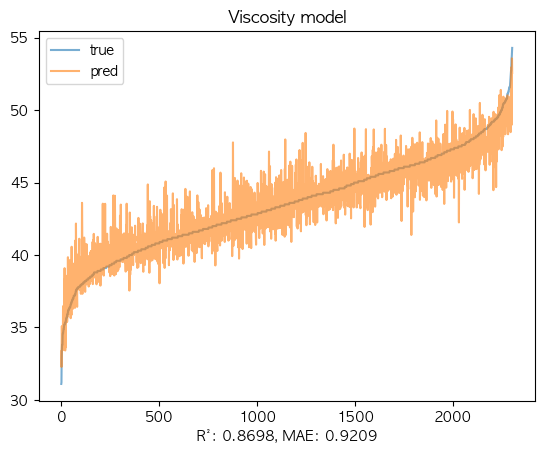

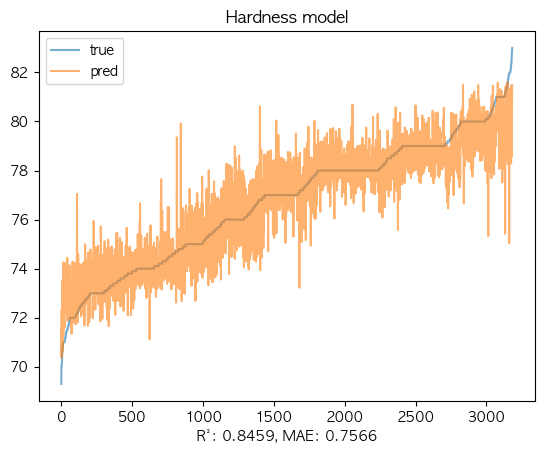

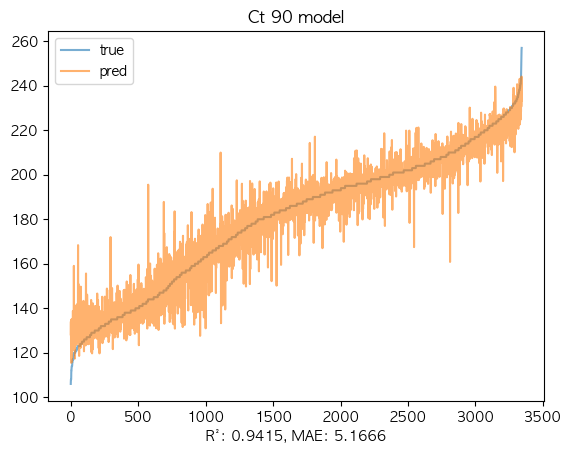

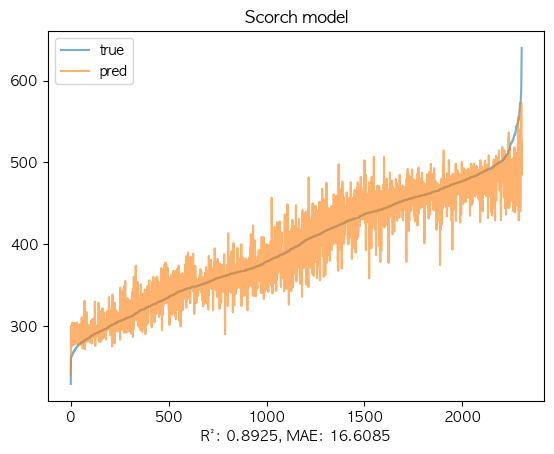

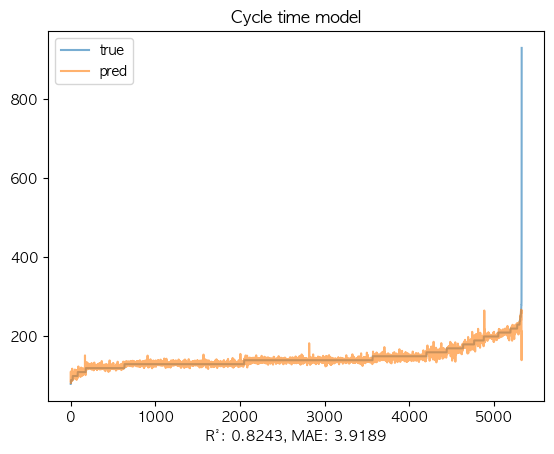

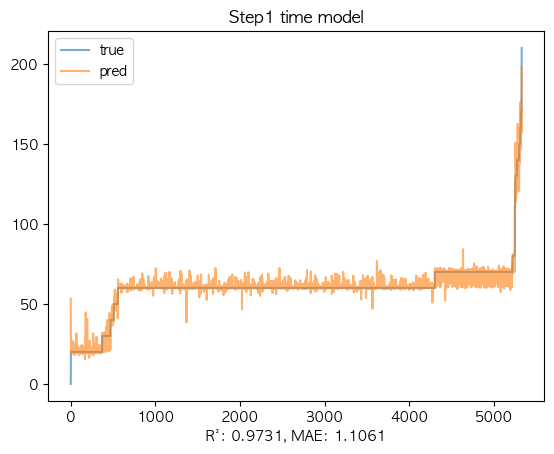

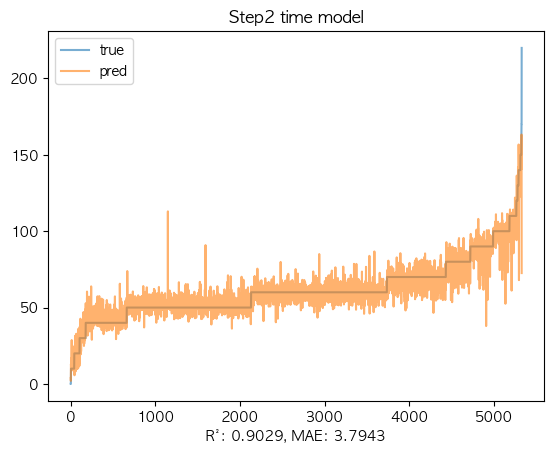

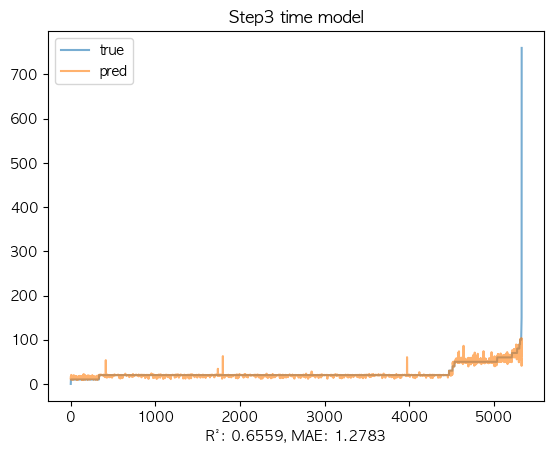

In [63]:
# 예측 및 평가
# 점도 모델 예측 및 평가
y_v_pred = model_v_best.predict(X_v_test)
r2_v = r2_score(y_v_test, y_v_pred)
mape_v = mean_absolute_percentage_error(y_v_test, y_v_pred)
mae_v = np.mean(np.abs(y_v_test - y_v_pred))
rmse_v = np.sqrt(np.mean((y_v_test - y_v_pred) ** 2))
# 점도 모델 시각화
plot_predictions(y_v_test, y_v_pred, "Viscosity model", subtitle="R²: {:.4f}, MAE: {:.4f}".format(r2_v, mae_v))

# 경도 모델 예측 및 평가
y_h_pred = model_h_best.predict(X_h_test)
r2_h = r2_score(y_h_test, y_h_pred)
mape_h = mean_absolute_percentage_error(y_h_test, y_h_pred)
mae_h = np.mean(np.abs(y_h_test - y_h_pred))
rmse_h = np.sqrt(np.mean((y_h_test - y_h_pred) ** 2))
# 경도 모델 시각화
plot_predictions(y_h_test, y_h_pred, "Hardness model", subtitle="R²: {:.4f}, MAE: {:.4f}".format(r2_h, mae_h))

# Ct 90 모델 예측 및 평가
y_ct_pred = model_ct_best.predict(X_ct_test)
r2_ct = r2_score(y_ct_test, y_ct_pred)
mape_ct = mean_absolute_percentage_error(y_ct_test, y_ct_pred)
mae_ct = np.mean(np.abs(y_ct_test - y_ct_pred))
rmse_ct = np.sqrt(np.mean((y_ct_test - y_ct_pred) ** 2))
# Ct 90 모델 시각화
plot_predictions(y_ct_test, y_ct_pred, "Ct 90 model", subtitle="R²: {:.4f}, MAE: {:.4f}".format(r2_ct, mae_ct))

# Scorch 모델 예측 및 평가
y_st_pred = model_st_best.predict(X_st_test)
r2_st = r2_score(y_st_test, y_st_pred)
mape_st = mean_absolute_percentage_error(y_st_test, y_st_pred)
mae_st = np.mean(np.abs(y_st_test - y_st_pred))
rmse_st = np.sqrt(np.mean((y_st_test - y_st_pred) ** 2))
# Scorch 모델 시각화
plot_predictions(y_st_test, y_st_pred, "Scorch model", subtitle="R²: {:.4f}, MAE: {:.4f}".format(r2_st, mae_st))

# 사이클타임 모델 예측 및 평가
y_c_pred = model_c_best.predict(X_c_test)
r2_c = r2_score(y_c_test, y_c_pred)
mape_c = mean_absolute_percentage_error(y_c_test, y_c_pred)
mae_c = np.mean(np.abs(y_c_test - y_c_pred))
rmse_c = np.sqrt(np.mean((y_c_test - y_c_pred) ** 2))
# 사이클타임 모델 시각화
plot_predictions(y_c_test, y_c_pred, "Cycle time model", subtitle="R²: {:.4f}, MAE: {:.4f}".format(r2_c, mae_c))

# step1_time 모델 예측 및 평가
y_s1_pred = model_s1_best.predict(X_s1_test)
r2_s1 = r2_score(y_s1_test, y_s1_pred)
mape_s1 = mean_absolute_percentage_error(y_s1_test, y_s1_pred)
mae_s1 = np.mean(np.abs(y_s1_test - y_s1_pred))
rmse_s1 = np.sqrt(np.mean((y_s1_test - y_s1_pred) ** 2))
# step1_time 모델 시각화
plot_predictions(y_s1_test, y_s1_pred, "Step1 time model", subtitle="R²: {:.4f}, MAE: {:.4f}".format(r2_s1, mae_s1))

# step2_time 모델 예측 및 평가
y_s2_pred = model_s2_best.predict(X_s2_test)
r2_s2 = r2_score(y_s2_test, y_s2_pred)
mape_s2 = mean_absolute_percentage_error(y_s2_test, y_s2_pred)
mae_s2 = np.mean(np.abs(y_s2_test - y_s2_pred))
rmse_s2 = np.sqrt(np.mean((y_s2_test - y_s2_pred) ** 2))
# step2_time 모델 시각화
plot_predictions(y_s2_test, y_s2_pred, "Step2 time model", subtitle="R²: {:.4f}, MAE: {:.4f}".format(r2_s2, mae_s2))

# step3_time 모델 예측 및 평가
y_s3_pred = model_s3_best.predict(X_s3_test)
r2_s3 = r2_score(y_s3_test, y_s3_pred)
mape_s3 = mean_absolute_percentage_error(y_s3_test, y_s3_pred)
mae_s3 = np.mean(np.abs(y_s3_test - y_s3_pred))
rmse_s3 = np.sqrt(np.mean((y_s3_test - y_s3_pred) ** 2))
# step3_time 모델 시각화
plot_predictions(y_s3_test, y_s3_pred, "Step3 time model", subtitle="R²: {:.4f}, MAE: {:.4f}".format(r2_s3, mae_s3))

In [64]:
# 저장해놓고 실행할 때 불러오기
print("학습 제품명: ", cluster_dict[train_cluster]['products'])

ct_trained_products = df3[["작업지시번호-배치", "Ct 90_결과"]].dropna().reset_index(drop=True)
print("제품명: ", set(cluster_dict[train_cluster]['products']) - set(ct_trained_products["작업지시번호-배치"].map(lambda x: x[6:16]).unique()), ", Ct 90 학습 불가")

st_trained_products = df3[["작업지시번호-배치", f"Scorch ({cluster_dict[train_cluster]['var']})_결과"]].dropna().reset_index(drop=True)
print("제품명: ", set(cluster_dict[train_cluster]['products']) - set(st_trained_products["작업지시번호-배치"].map(lambda x: x[6:16]).unique()), ", Scorch T5 학습 불가")

v_trained_products = df3[["작업지시번호-배치", f"Vm ({cluster_dict[train_cluster]['var']})_결과"]].dropna().reset_index(drop=True)
print("제품명: ", set(cluster_dict[train_cluster]['products']) - set(v_trained_products["작업지시번호-배치"].map(lambda x: x[6:16]).unique()), ", Viscosity 학습 불가")

h_trained_products = df3[["작업지시번호-배치", "경도_결과"]].dropna().reset_index(drop=True)
print("제품명: ", set(cluster_dict[train_cluster]['products']) - set(h_trained_products["작업지시번호-배치"].map(lambda x: x[6:16]).unique()), ", Hardness 학습 불가")

학습 제품명:  ['FFWED70284', 'FFWED70007', 'FFWED70267', 'FFWED70103', 'FFWED70199', 'FFSED70438', 'FFWED70033', 'FFWES60194', 'FFSED70498', 'FFSED70533', 'FFWED70321']
제품명:  set() , Ct 90 학습 불가
제품명:  set() , Scorch T5 학습 불가
제품명:  set() , Viscosity 학습 불가
제품명:  {'FFWES60194'} , Hardness 학습 불가


# 저장

In [65]:
model_ct_best.save_model(f"./{train_cluster}_model_ct90.json")
model_st_best.save_model(f"./{train_cluster}_model_st.json")
model_v_best.save_model(f"./{train_cluster}_model_v.json")
model_h_best.save_model(f"./{train_cluster}_model_h.json")
model_c_best.save_model(f"./{train_cluster}_model_c.json")
model_s1_best.save_model(f"./{train_cluster}_model_s1.json")
model_s2_best.save_model(f"./{train_cluster}_model_s2.json")
model_s3_best.save_model(f"./{train_cluster}_model_s3.json")

df3.to_parquet(f"./{train_cluster}_train_df.parquet", index=False)
recipe_df6.to_parquet(f"./{train_cluster}_recipe_df.parquet", index=False)

save_dict = {
    "cluster": train_cluster,
    "products": cluster_dict[train_cluster]['products'],
    "features": features,
    "train_df": {"path": f"./{train_cluster}_train_df.parquet", "shape": df3.shape},
    "recipe_df": {"path": f"./{train_cluster}_recipe_df.parquet", "shape": recipe_df6.shape},
    "ct_trained_products": list(ct_trained_products["작업지시번호-배치"].map(lambda x: x[6:16]).unique()),
    "st_trained_products": list(st_trained_products["작업지시번호-배치"].map(lambda x: x[6:16]).unique()),
    "v_trained_products": list(v_trained_products["작업지시번호-배치"].map(lambda x: x[6:16]).unique()),
    "h_trained_products": list(h_trained_products["작업지시번호-배치"].map(lambda x: x[6:16]).unique()),
    "ct_model": {"path": f"./{train_cluster}_model_ct90.json", "metrics": {"R2": r2_ct, "MAPE": mape_ct, "RMSE": rmse_ct, "MAE": mae_ct}},
    "st_model": {"path": f"./{train_cluster}_model_st.json", "metrics": {"R2": r2_st, "MAPE": mape_st, "RMSE": rmse_st, "MAE": mae_st}},
    "v_model": {"path": f"./{train_cluster}_model_v.json", "metrics": {"R2": r2_v, "MAPE": mape_v, "RMSE": rmse_v, "MAE": mae_v}},
    "h_model": {"path": f"./{train_cluster}_model_h.json", "metrics": {"R2": r2_h, "MAPE": mape_h, "RMSE": rmse_h, "MAE": mae_h}},
    "c_model": {"path": f"./{train_cluster}_model_c.json", "metrics": {"R2": r2_c, "MAPE": mape_c, "RMSE": rmse_c, "MAE": mae_c}},
    "s1_model": {"path": f"./{train_cluster}_model_s1.json", "metrics": {"R2": r2_s1, "MAPE": mape_s1, "RMSE": rmse_s1, "MAE": mae_s1}},
    "s2_model": {"path": f"./{train_cluster}_model_s2.json", "metrics": {"R2": r2_s2, "MAPE": mape_s2, "RMSE": rmse_s2, "MAE": mae_s2}},
    "s3_model": {"path": f"./{train_cluster}_model_s3.json", "metrics": {"R2": r2_s3, "MAPE": mape_s3, "RMSE": rmse_s3, "MAE": mae_s3}},
}

# save_dict 저장
import json
with open(f"./{train_cluster}_train_info.json", "w") as f:
    json.dump(save_dict, f, ensure_ascii=False, indent=4)

# 최적화

In [66]:
import pandas as pd
import json
import xgboost as xgb
from utils import *
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

user = "dogyeom"

In [67]:
# # import pandas as pd
# # import json
# # import xgboost as xgb

# # user = "dogyeom"

# cluster_dict = {
#     'cluster1': {'products': ["FFWED70284","FFWED70007","FFWED70267","FFWED70103","FFWED70199","FFSED70438","FFWED70033"],
#                  'var': 'T5'},
#     'cluster2': {'products': ["FFWES60194","FFSED70498","FFSED70533","FFWED70321"],
#                  'var': 'T5'},
#     'cluster3': {'products': ["FFWED70019","FFWED70102","FFWED70283","FFHED70076","FFWED70338"],
#                  'var': 'T3'},
#     'cluster4': {'products': ["FFHED70014","FFSED70032","FFHED70147"],
#                  'var': 'T3'},
#     'cluster5': {'products': ["FFHED60009","FFHED60006"], 
#                  'var': 'T3'}
#     }

In [96]:
path = "/Users/" + user + "/Library/CloudStorage/OneDrive-앰버로드/문서 - Solution/2502_화승/20.수행/22.분석과제/250408_분석_sm"

mix_df = pd.read_csv(f"{path}/mix_df.csv")
qa_df = pd.read_csv(f"{path}/qa_df.csv") # 목표값을 추출하기 위해 필요, UI에서 목표값을 받는다면 로딩하지 않아도 됨

In [141]:
run_cluster = "cluster1"
print(f"클러스터: {run_cluster}, 학습 제품명: {cluster_dict[run_cluster]['products']}")

with open(f"./{run_cluster}_train_info.json", "r") as f:
    load_dict = json.load(f)

train_df = pd.read_parquet(f"./{run_cluster}_train_df.parquet")
recipe_df = pd.read_parquet(f"./{run_cluster}_recipe_df.parquet")

# load model
model_ct_best = xgb.XGBRegressor()
model_ct_best.load_model(load_dict["ct_model"]["path"])

model_st_best = xgb.XGBRegressor()
model_st_best.load_model(load_dict["st_model"]["path"])

model_v_best = xgb.XGBRegressor()
model_v_best.load_model(load_dict["v_model"]["path"])

model_h_best = xgb.XGBRegressor()
model_h_best.load_model(load_dict["h_model"]["path"])

model_c_best = xgb.XGBRegressor()
model_c_best.load_model(load_dict["c_model"]["path"])

model_s1_best = xgb.XGBRegressor()
model_s1_best.load_model(load_dict["s1_model"]["path"])

model_s2_best = xgb.XGBRegressor()
model_s2_best.load_model(load_dict["s2_model"]["path"])

model_s3_best = xgb.XGBRegressor()
model_s3_best.load_model(load_dict["s3_model"]["path"])

클러스터: cluster1, 학습 제품명: ['FFWED70284', 'FFWED70007', 'FFWED70267', 'FFWED70103', 'FFWED70199', 'FFSED70438', 'FFWED70033', 'FFWES60194', 'FFSED70498', 'FFSED70533', 'FFWED70321']


In [72]:
user_product = 'FFWED70284'

if user_product not in load_dict["ct_trained_products"]:
    raise ValueError(f"{user_product}는 Ct 90 모델 학습에 포함되지 않은 제품입니다.")

if user_product not in load_dict["st_trained_products"]:
    raise ValueError(f"{user_product}는 Scorch 모델 학습에 포함되지 않은 제품입니다.")

if user_product not in load_dict["v_trained_products"]:
    raise ValueError(f"{user_product}는 Viscosity 모델 학습에 포함되지 않은 제품입니다.")

if user_product not in load_dict["h_trained_products"]:
    raise ValueError(f"{user_product}는 Hardness 모델 학습에 포함되지 않은 제품입니다.")

In [103]:
# 사용자에게 입력 받는 품질 지표 목표값
ct_target = int(qa_df[(qa_df["제품코드"] == user_product) & (qa_df["검사항목명"] == "Ct 90")]["기준"].value_counts().index[0].split("±")[0])
# ct_target = None
st_target = int(qa_df[(qa_df["제품코드"] == user_product) & (qa_df["검사항목명"] == f"Scorch ({cluster_dict[run_cluster]['var']})")]["기준"].value_counts().index[0].split("±")[0])
# st_target = None
v_target = int(qa_df[(qa_df["제품코드"] == user_product) & (qa_df["검사항목명"] == f"Vm ({cluster_dict[run_cluster]['var']})")]["기준"].value_counts().index[0].split("±")[0])
# v_target = None
h_target = int(qa_df[(qa_df["제품코드"] == user_product) & (qa_df["검사항목명"] == "경도")]["기준"].value_counts().index[0].split("±")[0])
# h_target = None
c_target = train_df[train_df["작업지시번호-배치"].map(lambda x:x[6:16]) == user_product]["cycle time"].quantile(0.25)
# c_target = None

# 사용자에게 입력 받는 날씨값
current_weather_conditions = {
    "TA_AVG": 29,
    "TA_MAX": 35.6,
    "TA_MIN": 23.9,
    "HM_AVG": 78.6,
}

print("목표 Ct 90: ", ct_target)
print("목표 Scorch (T5): ", st_target)
print("목표 Viscosity: ", v_target)
print("목표 Hardness: ", h_target)
print("목표 Cycle time: ", c_target)
print("현재 날씨 조건: ", current_weather_conditions)
print("제품:", user_product)

temp_key = mix_df[mix_df["아이템코드"] == user_product]["작업지시번호-배치"].iloc[-42]
ff = recipe_df[recipe_df["작업지시번호-배치"] == temp_key]["필팩터"].values[0]
print("필팩터:", ff)

목표 Ct 90:  200
목표 Scorch (T5):  450
목표 Viscosity:  47
목표 Hardness:  78
목표 Cycle time:  130.0
현재 날씨 조건:  {'TA_AVG': 29, 'TA_MAX': 35.6, 'TA_MIN': 23.9, 'HM_AVG': 78.6}
제품: FFWED70284
필팩터: 0.7783743872086526


In [130]:
range = "cluster"  # "product" or "cluster"
features = load_dict["features"]
n_opt_features = ["TA_AVG", "TA_MAX", "TA_MIN", "HM_AVG", "cluster", "필팩터"]
ref_features = ["step1_time", "step2_time", "step3_time"]
opt_features = [f for f in features if f not in n_opt_features]
opt_features = [f for f in opt_features if f not in ref_features]

fixed_df = pd.DataFrame([current_weather_conditions], columns=n_opt_features)
fixed_df["cluster"] = 6
fixed_df["필팩터"] = ff
full_df = pd.DataFrame(columns=features)
for col in features:
    if col in n_opt_features:
        full_df[col] = fixed_df[col]
    else:
        full_df[col] = 0
        
fixed_params = full_df[n_opt_features].iloc[0]

objective_function = create_objective_function(
    fixed_params=fixed_params, 
    all_features_list=features, 
    opt_features_list=opt_features,
    ct_target=ct_target,
    st_target=st_target,
    c_target=c_target,
    v_target=v_target, 
    h_target=h_target, 
    ct_model=model_ct_best,
    st_model=model_st_best,
    c_model=model_c_best,
    v_model=model_v_best,
    h_model=model_h_best,
    penalty_invalid=1e6,
    scales={"ct": load_dict["ct_model"]["metrics"]["RMSE"], 
            "st": load_dict["st_model"]["metrics"]["RMSE"],
            "c": load_dict["c_model"]["metrics"]["RMSE"],
            "v": load_dict["v_model"]["metrics"]["RMSE"],
            "h": load_dict["h_model"]["metrics"]["RMSE"]},
    weights={"ct": 2.0, "st": 3.0, "c": 1.0, "v": 2.0, "h": 2.0}
)

space = []
print("--- 최적화 탐색 범위 설정---")
temp_df = train_df[train_df["작업지시번호-배치"].map(lambda x: x[6:16]) == user_product]

for feature in opt_features:
    # 결측/빈 시리즈 대비
    if range == "product":
        s = temp_df[feature].dropna()
    elif range == "cluster":
        s = train_df[feature].dropna()
    if s.empty:
        # 전역 기본값이나 현재 full_df 값으로 대체 (필요에 맞게 조정)
        q05 = q95 = float(full_df.iloc[0].get(feature, 0.0))
    else:
        q05 = float(s.quantile(0.05))
        q95 = float(s.quantile(0.95))

    if not np.isfinite(q05) or not np.isfinite(q95) or q05 >= q95 or np.isclose(q05, q95):
        # ✅ 고정값은 Categorical 한 값으로
        dim = Categorical([q05], name=feature)
        print(f"feature '{feature}': 고정값 {q05:.2f} 으로 설정")
    else:
        # ✅ 범위 차원은 Real로 (이름 반드시 부여)
        dim = Real(q05, q95, name=feature)
        print(f"feature '{feature}': 범위 [{q05:.2f}, {q95:.2f}] 으로 설정")
    space.append(dim)
    
# 최적화 실행
print("최적화 시작...")
res = gp_minimize(
    objective_function, 
    space, 
    n_calls=300, 
    random_state=random_seed, 
    n_jobs=-1,
    n_initial_points=50,       
    acq_func="gp_hedge",             
    xi=0.05,                  
    noise="gaussian",        
    n_restarts_optimizer=10
)
print("최적화 완료.")

--- 최적화 탐색 범위 설정---
feature 'step1_Rotor speed': 범위 [31.00, 52.00] 으로 설정
feature 'step2_Rotor speed': 범위 [31.00, 51.88] 으로 설정
feature 'step3_Rotor speed': 범위 [25.67, 41.00] 으로 설정
feature 'step1_mix온도': 범위 [74.00, 105.00] 으로 설정
feature 'step2_mix온도': 범위 [106.00, 145.00] 으로 설정
feature 'step3_mix온도': 범위 [130.00, 148.00] 으로 설정
최적화 시작...
Ct 90: 210.8636 (target 200) | Scorch: 376.8841 (target 450) | Cycle Time: 164.7488 (target 130.0) | Viscosity: 44.3132 (target 47) | Hardness: 76.3291 (target 78)
Ct 90: 209.7992 (target 200) | Scorch: 334.3642 (target 450) | Cycle Time: 144.0723 (target 130.0) | Viscosity: 44.8778 (target 47) | Hardness: 76.0219 (target 78)
Ct 90: 214.5443 (target 200) | Scorch: 416.2463 (target 450) | Cycle Time: 155.8227 (target 130.0) | Viscosity: 43.4857 (target 47) | Hardness: 76.3813 (target 78)
Ct 90: 195.5631 (target 200) | Scorch: 345.2541 (target 450) | Cycle Time: 141.8662 (target 130.0) | Viscosity: 44.3803 (target 47) | Hardness: 76.1150 (target 78)
Ct 90: 21


              최적화 최종 결과
-> 최소 손실값(objective): 8.4407
   예측 Ct90: 194.2552
   예측 Scorch: 450.9578
   예측 Cycle Time: 131.7617
   예측 Viscosity: 45.6241
   예측 Hardness: 75.8598


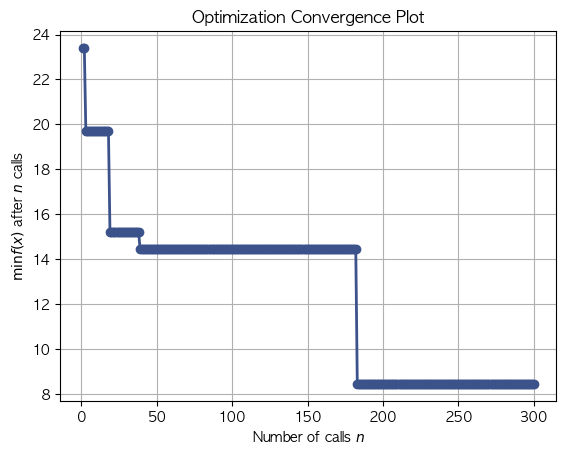

In [131]:
# 0) space에서 최적화 변수 이름을 확보 (가장 안전)
opt_names = [dim.name for dim in space]      # 예: ["step1_mix온도", "step1_mix온도Xtime", ...]
optimal_opt_params = res.x                   # skopt가 반환한 최적 해

# 1) 고정 + 최적화 파라미터 딕셔너리 결합
final_params_dict = dict(fixed_params)       # 고정 변수 투입
final_params_dict.update(dict(zip(opt_names, optimal_opt_params)))

# 2) 영향변수(ref_features) 계산 주입 (예: stepk_time = mix온도Xtime / mix온도)
final_params_dict = inject_ref_features(final_params_dict)   # 또는 _inject_product_features(...)

# 3) 모델 학습 시 사용한 피처 순서로 입력 벡터 구성
#    features == all_features_list (학습 시 사용한 순서와 동일해야 함)
final_params_vector = [final_params_dict.get(f, np.nan) for f in features]

# 4) 유효성 검사 (NaN/inf 방지)
arr = np.array(final_params_vector, dtype=float)
if not np.isfinite(arr).all():
    raise ValueError(f"최종 파라미터에 NaN/inf 존재: {[ (f, final_params_dict.get(f)) for f in features if not np.isfinite(final_params_dict.get(f, np.nan)) ]}")

# 5) 최종 입력 DF
optimal_df = pd.DataFrame([final_params_vector], columns=features)

# 6) 예측 및 결과 출력
pred_ct  = model_ct_best.predict(optimal_df)[0]
pred_st  = model_st_best.predict(optimal_df)[0]
pred_c   = model_c_best.predict(optimal_df)[0]
pred_v   = model_v_best.predict(optimal_df)[0]
pred_h   = model_h_best.predict(optimal_df)[0]

print("\n" + "=" * 50)
print("              최적화 최종 결과")
print("=" * 50)
print(f"-> 최소 손실값(objective): {res.fun:.4f}")  
print(f"   예측 Ct90: {pred_ct:.4f}")
print(f"   예측 Scorch: {pred_st:.4f}")
print(f"   예측 Cycle Time: {pred_c:.4f}")
print(f"   예측 Viscosity: {pred_v:.4f}")
print(f"   예측 Hardness: {pred_h:.4f}")

# 7) 수렴 플롯
plt.figure()
plot_convergence(res)
plt.title("Optimization Convergence Plot")
plt.show()

In [136]:
print("예상되는 Ct 90:", model_ct_best.predict(optimal_df)[0])
print("예상되는 Scorch:", model_st_best.predict(optimal_df)[0])
print("예상되는 Cycle Time:", model_c_best.predict(optimal_df)[0])
print("예상되는 Viscosity:", model_v_best.predict(optimal_df)[0])   
print("예상되는 Hardness:", model_h_best.predict(optimal_df)[0])

print("=" * 50)
print("              기존 데이터 통계")
print("=" * 50)
print("[Ct 90]")
print(f"min: {temp_df['Ct 90_결과'].min():.4f}")
print(f"25%: {temp_df['Ct 90_결과'].quantile(0.25):.4f}")
print(f"mean: {temp_df['Ct 90_결과'].mean():.4f}")
print(f"75%: {temp_df['Ct 90_결과'].quantile(0.75):.4f}")
print(f"max: {temp_df['Ct 90_결과'].max():.4f}")

print("\n[Scorch]")
print("min: {}".format(temp_df[f"Scorch ({cluster_dict[run_cluster]['var']})_결과"].min()))
print("25%: {}".format(temp_df[f"Scorch ({cluster_dict[run_cluster]['var']})_결과"].quantile(0.25)))
print("mean: {}".format(temp_df[f"Scorch ({cluster_dict[run_cluster]['var']})_결과"].mean()))
print("75%: {}".format(temp_df[f"Scorch ({cluster_dict[run_cluster]['var']})_결과"].quantile(0.75)))
print("max: {}".format(temp_df[f"Scorch ({cluster_dict[run_cluster]['var']})_결과"].max()))

print("\n[Viscosity]")
print("min: {}".format(temp_df[f"Vm ({cluster_dict[run_cluster]['var']})_결과"].min()))
print("25%: {}".format(temp_df[f"Vm ({cluster_dict[run_cluster]['var']})_결과"].quantile(0.25)))
print("mean: {}".format(temp_df[f"Vm ({cluster_dict[run_cluster]['var']})_결과"].mean()))
print("75%: {}".format(temp_df[f"Vm ({cluster_dict[run_cluster]['var']})_결과"].quantile(0.75)))
print("max: {}".format(temp_df[f"Vm ({cluster_dict[run_cluster]['var']})_결과"].max()))

print("\n[Hardness]")
print(f"min: {temp_df['경도_결과'].min():.4f}")
print(f"25%: {temp_df['경도_결과'].quantile(0.25):.4f}")
print(f"mean: {temp_df['경도_결과'].mean():.4f}")
print(f"75%: {temp_df['경도_결과'].quantile(0.75):.4f}")
print(f"max: {temp_df['경도_결과'].max():.4f}")

print("\n[Cycle Time]")
print(f"min: {temp_df['cycle time'].min():.4f}")
print(f"25%: {temp_df['cycle time'].quantile(0.25):.4f}")
print(f"mean: {temp_df['cycle time'].mean():.4f}")
print(f"75%: {temp_df['cycle time'].quantile(0.75):.4f}")
print(f"max: {temp_df['cycle time'].max():.4f}")

예상되는 Ct 90: 194.2552
예상되는 Scorch: 450.95776
예상되는 Cycle Time: 131.76172
예상되는 Viscosity: 45.624065
예상되는 Hardness: 75.859795
              기존 데이터 통계
[Ct 90]
min: 168.0000
25%: 207.0000
mean: 212.1769
75%: 217.0000
max: 237.0000

[Scorch]
min: 365.0
25%: 455.0
mean: 472.1556603773585
75%: 490.0
max: 617.0

[Viscosity]
min: 37.6
25%: 43.6
mean: 44.84983153638814
75%: 46.1
max: 53.3

[Hardness]
min: 74.0000
25%: 78.0000
mean: 78.5936
75%: 79.3000
max: 83.4000

[Cycle Time]
min: 110.0000
25%: 130.0000
mean: 141.3779
75%: 140.0000
max: 570.0000


## 제품코드 별 최적 배합표

In [138]:
final_params_dict["step1_time"] = model_s1_best.predict(pd.DataFrame([final_params_dict])[["step1_Rotor speed", "step1_mix온도", "TA_AVG", "HM_AVG", "TA_MAX", "TA_MIN", "필팩터", "cluster"]])[0]
final_params_dict["step2_time"] = model_s2_best.predict(pd.DataFrame([final_params_dict])[["step2_Rotor speed", "step2_mix온도", "TA_AVG", "HM_AVG", "TA_MAX", "TA_MIN", "필팩터", "cluster"]])[0]
final_params_dict["step3_time"] = model_s3_best.predict(pd.DataFrame([final_params_dict])[["step3_Rotor speed", "step3_mix온도", "TA_AVG", "HM_AVG", "TA_MAX", "TA_MIN", "필팩터", "cluster"]])[0]
final_params_dict

{'TA_AVG': 29.0,
 'TA_MAX': 35.6,
 'TA_MIN': 23.9,
 'HM_AVG': 78.6,
 'cluster': 6.0,
 '필팩터': 0.7783743872086526,
 'step1_Rotor speed': 51.67618099712476,
 'step2_Rotor speed': 45.0272839617234,
 'step3_Rotor speed': 37.833851246533754,
 'step1_mix온도': 99.39698308026607,
 'step2_mix온도': 130.29456139269263,
 'step3_mix온도': 135.44732408162673,
 'step1_time': 56.994553,
 'step2_time': 42.45715,
 'step3_time': 24.474817}

In [139]:
for k in [1,2,3]:
    t = final_params_dict.get(f"step{k}_time", None)
    m = final_params_dict.get(f"step{k}_mix온도", None)
    mt = final_params_dict.get(f"step{k}_mix온도Xtime", None)
    print(f"step{k}_time: {final_params_dict.get(f'step{k}_time', None)}")
    print(f"step{k}_mix온도: {final_params_dict.get(f'step{k}_mix온도', None)}")
    print(f"step{k}_Rotor speed: {final_params_dict.get(f'step{k}_Rotor speed', None)}")
    print()
    
print("필팩터:", final_params_dict.get("필팩터", None))

step1_time: 56.99455261230469
step1_mix온도: 99.39698308026607
step1_Rotor speed: 51.67618099712476

step2_time: 42.457149505615234
step2_mix온도: 130.29456139269263
step2_Rotor speed: 45.0272839617234

step3_time: 24.474817276000977
step3_mix온도: 135.44732408162673
step3_Rotor speed: 37.833851246533754

필팩터: 0.7783743872086526


In [142]:
# 기존 배합표
temp_key = mix_df[mix_df["아이템코드"] == user_product]["작업지시번호-배치"].iloc[-100]
org_mix_df = mix_df[mix_df["작업지시번호-배치"] == temp_key].reset_index(drop=True)[["STEP", "시간", "온도", "조건", "램압력", "로터속도"]]

org_mix_df["필팩터"] = None
org_mix_df.loc[0, "필팩터"] = recipe_df[recipe_df["작업지시번호-배치"] == temp_key]["필팩터"].values[0]

org_mix_df.to_csv(f"./{run_cluster}_{user_product}_org_mix_df.csv", index=False)
org_mix_df

,STEP,시간,온도,조건,램압력,로터속도,필팩터
0,1,NaN,NaN,NaN,5.0,50,0.778329
1,2,70.0,NaN,OR,5.0,50,None
2,3,NaN,NaN,NaN,5.0,40,None
3,4,NaN,135.0,OR,5.0,40,None
4,5,NaN,NaN,NaN,5.0,35,None
5,6,30.0,NaN,OR,5.0,35,None
6,7,NaN,NaN,NaN,5.0,30,None


In [143]:
# 최적 배합표
opt_mix_df = mix_df[mix_df["작업지시번호-배치"] == temp_key].reset_index(drop=True)[["STEP", "시간", "온도", "조건", "램압력", "로터속도"]].copy()
opt_mix_df.loc[1, "시간"]  = round(final_params_dict.get("step1_time", None), 2)
opt_mix_df.loc[1, "온도"]  = round(final_params_dict.get("step1_mix온도", None), 2)
opt_mix_df.loc[1, "로터속도"]  = round(final_params_dict.get("step1_Rotor speed", None), 2)
opt_mix_df.loc[1, "조건"] = "OR"

opt_mix_df.loc[3, "시간"]  = round(final_params_dict.get("step2_time", None), 2)
opt_mix_df.loc[3, "온도"]  = round(final_params_dict.get("step2_mix온도", None), 2)
opt_mix_df.loc[3, "로터속도"]  = round(final_params_dict.get("step2_Rotor speed", None), 2)
opt_mix_df.loc[3, "조건"] = "OR"

opt_mix_df.loc[5, "시간"]  = round(final_params_dict.get("step3_time", None), 2)
opt_mix_df.loc[5, "온도"]  = round(final_params_dict.get("step3_mix온도", None), 2)
opt_mix_df.loc[5, "로터속도"]  = round(final_params_dict.get("step3_Rotor speed", None), 2)
opt_mix_df.loc[5, "조건"] = "OR"

opt_mix_df["필팩터"] = None
opt_mix_df.loc[0, "필팩터"] = round(final_params_dict.get("필팩터", None), 4)

opt_mix_df.to_csv(f"./{run_cluster}_{user_product}_optimal_mix_df.csv", index=False)
opt_mix_df

/var/folders/rc/4ht3xz_x5kn029j7xhvrx9lw0000gn/T/ipykernel_95649/2457251943.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  opt_mix_df.loc[1, "로터속도"]  = round(final_params_dict.get("step1_Rotor speed", None), 2)


,STEP,시간,온도,조건,램압력,로터속도,필팩터
0,1,NaN,NaN,NaN,5.0,50.00,0.7784
1,2,56.990002,99.40,OR,5.0,51.68,None
2,3,NaN,NaN,NaN,5.0,40.00,None
3,4,42.459999,130.29,OR,5.0,45.03,None
4,5,NaN,NaN,NaN,5.0,35.00,None
5,6,24.469999,135.45,OR,5.0,37.83,None
6,7,NaN,NaN,NaN,5.0,30.00,None


In [ ]:
# opt_mix_df의 "시간" 변수의 소수점 둘째 자리에서 반올림 
opt_mix_df["시간"] = opt_mix_df["시간"].round(2)

In [145]:
opt_mix_df

,STEP,시간,온도,조건,램압력,로터속도,필팩터
0,1,NaN,NaN,NaN,5.0,50.00,0.7784
1,2,56.99,99.40,OR,5.0,51.68,None
2,3,NaN,NaN,NaN,5.0,40.00,None
3,4,42.46,130.29,OR,5.0,45.03,None
4,5,NaN,NaN,NaN,5.0,35.00,None
5,6,24.47,135.45,OR,5.0,37.83,None
6,7,NaN,NaN,NaN,5.0,30.00,None


In [125]:
recipe_df = pd.read_csv(f"{path}/recipe_df.csv")
temp_key = log_df[log_df["제품코드"] == user_product]["작업지시번호-배치"].unique()[-100]
recipe_df[recipe_df["작업지시번호-배치"] == temp_key][["자재코드", "소요량", "STEP", "낙차중량", "공급중량", "제로중량", "투입유형"]]


,자재코드,소요량,STEP,낙차중량,공급중량,제로중량,투입유형
1520044,R3931-0208,64.700,1.0,0.0,0.05,NaN,M
1520045,R3941-0024,42.300,1.0,NaN,NaN,NaN,M
1520046,R3962-0002,2.390,1.0,NaN,NaN,NaN,M
1520047,R3968-0002,1.000,1.0,NaN,NaN,NaN,M
1520048,R3968-0018,0.610,1.0,0.0,NaN,NaN,M
1520049,R3951-0010,38.300,1.0,0.5,3.00,0.2,M
1520050,R3911-0231,40.000,1.0,0.0,NaN,NaN,M
1520051,R3981-0002,0.800,1.0,0.0,NaN,0.2,M
1520052,R3964-0013,0.050,1.0,0.0,NaN,NaN,M
1520053,R3966-0008,4.000,1.0,0.0,NaN,NaN,M


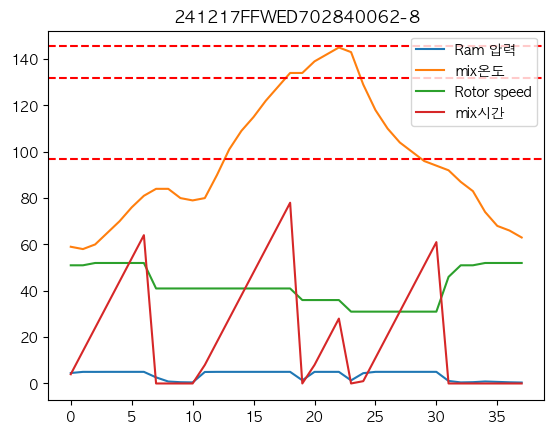

In [122]:
# log_df = pd.read_csv(f"{path}/log_df_10s.csv")

temp_key = log_df[log_df["제품코드"] == user_product]["작업지시번호-배치"].unique()[-100]
log_df[log_df["작업지시번호-배치"] == temp_key][["Ram 압력", "mix온도", "Rotor speed", "mix시간"]].reset_index(
    drop=True
).plot()
plt.title(temp_key)
plt.axhline(final_params_dict.get('step1_mix온도', None), color='r', linestyle='--')
plt.axhline(final_params_dict.get('step2_mix온도', None), color='r', linestyle='--')
plt.axhline(final_params_dict.get('step3_mix온도', None), color='r', linestyle='--')
plt.legend()
plt.show()